In [1]:
import pyodim
import hdr, hsda, common, hacc, mesh_ppi
from importlib import reload
import numpy as np

imports static in hsda
imports static in mesh


In [3]:
filename = "/home/meso/66_20231110_063000.pvol.h5"
#filename = "/g/data/kl02/jss548/aura/testing_files/hail/66_20231110_063000.pvol.h5"
radar_datasets = pyodim.read_odim(filename, lazy_load=False)

reload(mesh_ppi)
reload(hacc)
reload(common)

imports static in mesh


<module 'common' from '/home/meso/dev/pyhail/src/pyhail/common.py'>

In [9]:
"""
run retreivals that work on individual sweeps
"""

radar_datasets = hdr.pyodim(radar_datasets,
                            'DBZH',
                            'ZDR')

radar_datasets = hsda.pyodim(radar_datasets, 
                                filename, 
                                'DBZH', 
                                'ZDR', 
                                'RHOHV', 
                                'HCA',
                                [4000, 5500], 
                                [6, 7, 8])

"""
run retreivals that work on entire volume only
"""
#mesh
#build datasets
reflectivity_dataset = []
elevation_dataset = []
azimuth_dataset = []
range_dataset = []
radar_altitude = radar_datasets[0].attrs['height']
n_ppi = len(radar_datasets)
for sweep_idx in range(n_ppi):
    elv_value = radar_datasets[sweep_idx]['elevation'].data[0]
    #filter out birdbath scans
    if elv_value < 90:
        reflectivity_dataset.append(radar_datasets[sweep_idx]['DBZH'].values)
        elevation_dataset.append(radar_datasets[sweep_idx]['elevation'].data[0])
        azimuth_dataset.append(radar_datasets[sweep_idx]['azimuth'].values)
        range_dataset.append(radar_datasets[sweep_idx]['range'].values)
#run retrieval
ke_dict, shi_dict, mesh_dict, posh_dict = mesh_ppi.main(reflectivity_dataset,
                                                    elevation_dataset,
                                                    azimuth_dataset,
                                                    range_dataset,
                                                    radar_altitude,
                                                    [4000,5500])

#hacc
sweep0_idx = np.argmin(elevation_dataset)
#run retrieval
hacc_dict = hacc.main(radar_datasets[sweep0_idx]['DBZH'].values, 
                        radar_datasets[sweep0_idx]['hsda'].values,
                        mesh_dict['data'],
                        radar_datasets[sweep0_idx]['z'].values,
                        4000, 700,
                        sp_reflectivity_threshold=55)

#update data and metadata for new fields
radar_datasets[0] = radar_datasets[0].merge(
        {'ke': (("azimuth", "range"), ke_dict['data'][0]),
         'shi': (("azimuth", "range"), shi_dict['data']),
         'mesh': (("azimuth", "range"), mesh_dict['data']),
         'posh': (("azimuth", "range"), posh_dict['data']),
         'hacc': (("azimuth", "range"), hacc_dict['data']), })
radar_datasets[0] = common.add_pyodim_sweep_metadata(radar_datasets[sweep0_idx], 'ke', ke_dict)
radar_datasets[0] = common.add_pyodim_sweep_metadata(radar_datasets[sweep0_idx], 'shi', shi_dict)
radar_datasets[0] = common.add_pyodim_sweep_metadata(radar_datasets[sweep0_idx], 'mesh', mesh_dict)
radar_datasets[0] = common.add_pyodim_sweep_metadata(radar_datasets[sweep0_idx], 'posh', posh_dict)
radar_datasets[0] = common.add_pyodim_sweep_metadata(radar_datasets[sweep0_idx], 'hacc', hacc_dict)

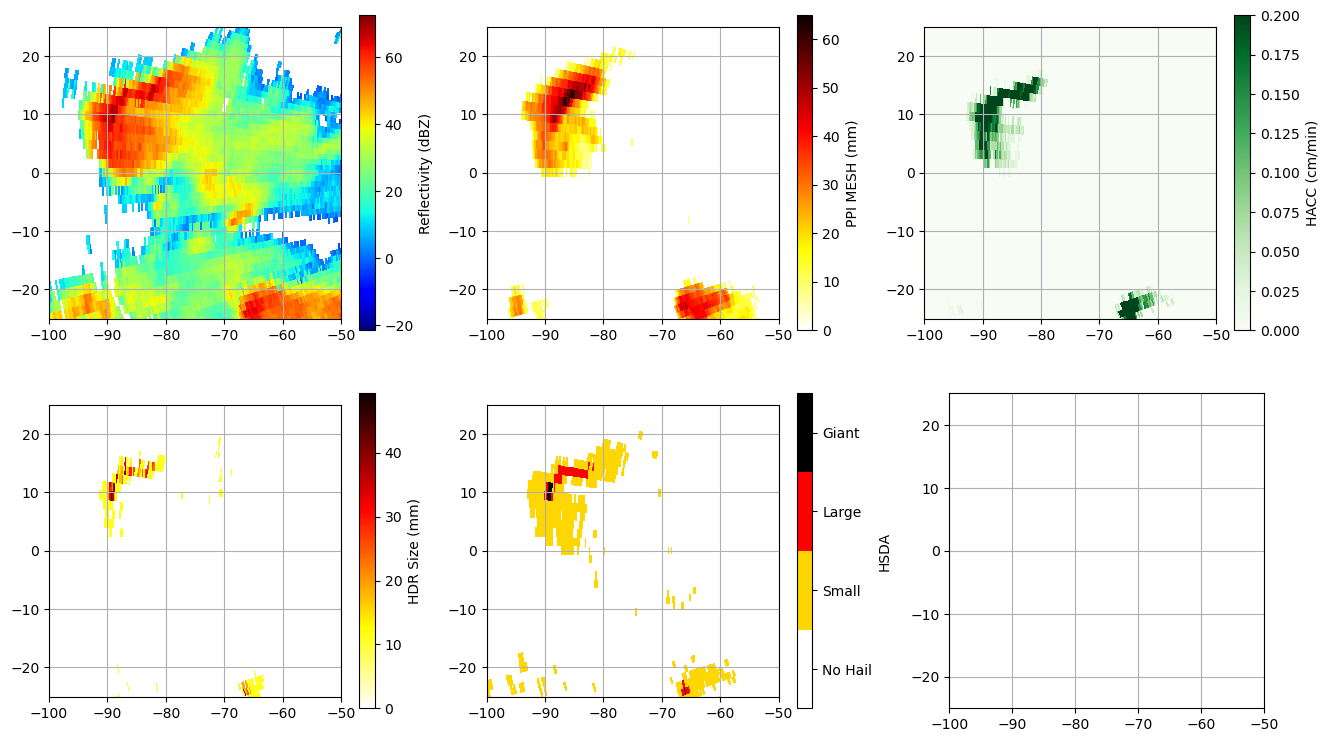

In [11]:
import cartopy.crs as ccrs
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import numpy as np

x_coords = radar_datasets[0]['x'].values/1000
y_coords = radar_datasets[0]['y'].values/1000
x_lim = [-100,-50]
y_lim = [-25, 25]
hsda_colors = [
    "White",
    "Gold",
    "Red",
    "Black",
    ]
hsda_cmap = colors.ListedColormap(hsda_colors) 

fig, axs = pl.subplots(nrows=2, ncols=3, figsize=(16, 9))
axs = axs.flatten()

im = axs[0].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['DBZH'].values, cmap='jet')
cbar = fig.colorbar(im, ax=axs[0], label='Reflectivity (dBZ)')

im = axs[1].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['mesh'].values, cmap='hot_r')
cbar = fig.colorbar(im, ax=axs[1], label='PPI MESH (mm)')

im = axs[2].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hacc'].values, cmap='Greens', vmax=0.2)
cbar = fig.colorbar(im, ax=axs[2], label='HACC (cm/min)')

im = axs[3].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hdr_size'].values, cmap='hot_r')
cbar = fig.colorbar(im, ax=axs[3], label='HDR Size (mm)')

im = axs[4].pcolormesh(x_coords, y_coords, radar_datasets[sweep0_idx]['hsda'].values, cmap=hsda_cmap, vmin=-0.5, vmax=3.5)
cbar = fig.colorbar(im, ax=axs[4], label='HSDA')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels(["No Hail", "Small", "Large", "Giant"])


for ax in axs:
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.grid()
    ax.set_aspect('equal', 'box')

